# GPI NRM tutoral for spectral IFU data
The example data is taken from the internal source (very stable, high quality), we have injected a faint secondary source.

In [1]:
# Imports
import sys, os, time
import numpy as np
from astropy.io import fits
import glob

from nrm_analysis import nrm_core, InstrumentData
from nrm_analysis.modeling.binarymodel import model_cp_uv

import emcee
import corner
# For Python2:
#from __future__ import print_function
#import cPickle as pickle
import pickle
import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tar_files = glob.glob("../example_data/example_gpi/injected*.fits")
test_cal = ["../example_data/example_gpi/S21040511S0{0:03d}_spdc.fits".format(ii+13) for ii in range(27-13+1)]


### specify the instrument, for GPI this will pull relevant info from the header
Information like band, wavelength of each slice, parallactic angle, etc.

In [3]:
gpit = InstrumentData.GPI(tar_files)
gpic = InstrumentData.GPI(tar_files)

" 
    This program (gpipoppy.py) uses DGS = 7770.1 * mm with M2 cardboard baffle
    GS OD from GPI Fundamental Values (Bauman GPI_Optical_Fundamental_Values.doc)
    
        http://dms.hia.nrc.ca/view.php?fDocumentId=2164

    and Lenox Laser measured hole diameter of G40S10 sample design,
    with average hole size in 

        LenoxSTScI_delivery_APOD_NRM10.[pdf xlsx]   (also on HIA's KT)

    All X,Y dimensions in m from center of mask in PM space
    All hole DIAMETERS are in m:

0.00154412427124
gpi_g10s4...
647.616269378
rotating by 115.0 deg -- hard coded.
	gpi_g10s40
	holeD	+0.596
		  x/m  	  y/m        r/m     r+h_rad/m  2(r+h)/m
		 -1.988	 +1.685     2.606      2.904      5.808 
		 -2.941	 +1.649     3.372      3.670      7.340 
		 -0.913	 -1.585     1.829      2.127      4.254 
		 -0.406	 -2.395     2.429      2.727      5.453 
		 +2.780	 +1.861     3.346      3.644      7.287 
		 +3.347	 -0.602     3.401      3.699      7.398 
		 -0.142	 +3.405     3.408      3.706      

In [5]:
fft = nrm_core.FringeFitter(gpit, oversample=5, savedir= "gpi_binary/", npix=101, interactive=False)
ffc = nrm_core.FringeFitter(gpic, oversample=5, savedir= "gpi_single/", npix=101, interactive=False)


In [8]:
# This can take a little while -- there is a parallelization option, set threads=n_threads
# output of this is long -- may also want to do this scripted instead of in notebook,
# Commenting out in this example, but uncomment the next line to run it.
#fft.fit_fringes(tar_files)

In [10]:
tardir = "gpi_binary/"
caldir = "gpi_single/"

# can clip deges of the spectrum with, e.g., clip=5
# sub_dir_tag must be specified, this routine will at all the directories containing
# the 'sub_dir_tag' string and read the files for each wavelength channel. 
calib = nrm_core.Calibrate([tardir, caldir], gpit, \
                        savedir ="gpi_calibrated/", sub_dir_tag = "140511")
calib.save_to_oifits("gpi_injected_binary_example.oifits")

In [25]:
oifile = "gpi_calibrated/gpi_injected_binary_example.oifits"
binset = nrm_core.BinaryAnalyze(oifile, savedir="gpi_calibrated/")
binset.cperr *= np.sqrt(10/3.0)
binset.cperr = np.sqrt(binset.cperr**2 + 0.2**2)

binset.plot="on"
coarse_params = binset.chi2map(nstep=25, threads=4, maxsep=150)

Opening gpi_calibrated/gpi_injected_binary_example.oifits
1 wavelength table with 37 wavelengths in total
1 target
1 array with 1 station
45 visibility^2 measurements
120 closure phase measurements
oifits has no parang info, moving on...
took 0.0967841148376s to assemble position grids
(2, 3, 120, 25, 25, 37)
(120, 37)
(25, 25, 37)
(37,)
Threads: 4
took 16.5740418434s to compute all chi^2 grid points
Best Contrast: [0.03753178]
Best Separation: [39.52847075]
Best PA: [18.43494882]


In [ ]:
# In this example there is no real sky PA, but this is relevant to other datasets
# This should be re-calibrated for other instruments with a known binary 
# to account for 180 deg flip confusion
npa = gpidata.avparang - gpidata.avcassang + 23.5 - 1.0
ucoords = binset.uvcoords[0,...].copy()
vcoords = binset.uvcoords[1,...].copy()

c, s = (np.cos(npa*np.pi/180.0), np.sin(npa*np.pi/180.0))

newu = c*ucoords - s*vcoords 
newv = s*ucoords + c*vcoords
binset.uvcoords[0,...] = newu
binset.uvcoords[1,...] = newv


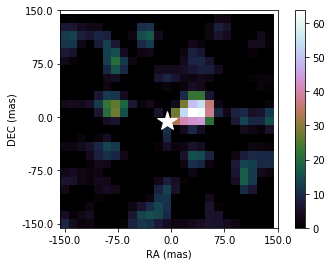

In [26]:
plt.figure()
plt.plot(25/2.0 -0.5,25/2.0 - 0.5, marker="*", color='w', markersize=20)
plt.imshow(np.sqrt(binset.significance), cmap="cubehelix", interpolation="nearest")
plt.xlabel("RA (mas)")
plt.ylabel("DEC (mas)")
plt.xticks(np.linspace(0, 25, 5), np.linspace(binset.ras.min(), binset.ras.max(), 4+1))
plt.yticks(np.linspace(0, 25, 5), np.linspace(binset.decs.min(), binset.decs.max(), 4+1))
plt.gca().invert_yaxis()
plt.colorbar()

### Now, the finer fit:

In [27]:
from nrm_analysis.modeling.binarymodel import model_cp_uv, model_t3amp_uv

def logl(data, err, model):
    """
    Likelihood given data, errors, and the model values
    These are all shape (nobservable, nwav)
    """
    #err*=np.sqrt(10.0/3.0)
    chi2 = np.sum(((data-model)/err)**2)
    loglike = -chi2/2.0
    return loglike

def cp_binary_model(params, binset, priors):
    """
    len(params) must be len(nrank) +2 (for sep, pa)
    """
    for i in range(len(params)):
        if (params[i] < priors[i][0] or params[i] > priors[i][1]):  
            return -np.inf

    contrasts = params[2:]
    seps = params[0]
    pas = params[1]

    model_cp = model_cp_uv(binset.uvcoords, contrasts, seps, pas, 1.0/binset.wavls)
    ll = logl(binset.cp, binset.cperr , model_cp)
    return ll

def all_binary_model(params, binset, priors):
    
    for i in range(len(params)):
        if (params[i] < priors[i][0] or params[i] > priors[i][1]):  
            return -np.inf

    contrasts = params[2:]
    seps = params[0]
    pas = params[1]

    model_cp = model_cp_uv(binset.uvcoords, contrasts, seps, pas, 1.0/binset.wavls)
    model_t3 = model_t3amp_uv(binset.uvcoords, contrasts, seps, pas, 1.0/binset.wavls)
    model_all = np.concatenate((model_cp, model_t3))
    obs_all = np.concatenate((binset.cp, binset.t3amp))
    obserr_all = np.concatenate((binset.cperr, binset.t3amperr))
    ll = logl(obs_all, obserr_all , model_all)
    return ll

In [28]:
# rearrange to put contrast @ the end
params = np.array([coarse_params[1], coarse_params[2], coarse_params[0]])
nwalkers = 150
niter = 2000
p0 = [params + 0.1*params*np.random.rand(len(params)) for i in range(nwalkers)]
priors = [ (10, 500), (-180.0, 180.0), (1e-5, 9.99e-1)]
sampler = emcee.EnsembleSampler(nwalkers, len(params), cp_binary_model,
                                threads=4, args=[binset, priors])
t0 = time.time()
pos, prob, state = sampler.run_mcmc(p0, 200)
sampler.reset()
t1 = time.time()
print( "burn in complete, took ", t1-t0, "s")
pos, prob, state = sampler.run_mcmc(pos, niter)
t2 = time.time()
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print ("ran mcmc, took", t2 - t1, "s")
chain = sampler.flatchain
fullchain = sampler.chain

burn in complete, took  144.423084021 s
Mean acceptance fraction: 0.645
ran mcmc, took 941.315778971 s


sep: 45.45496085595965 + 0.08193542725648228 - 0.08241232541674748
pa: 18.294869206764677 + 0.07329698668014117 - 0.07387937013036705
con: 0.040184694342825025 + 0.0001339860343017099 - 0.00013110557144229568


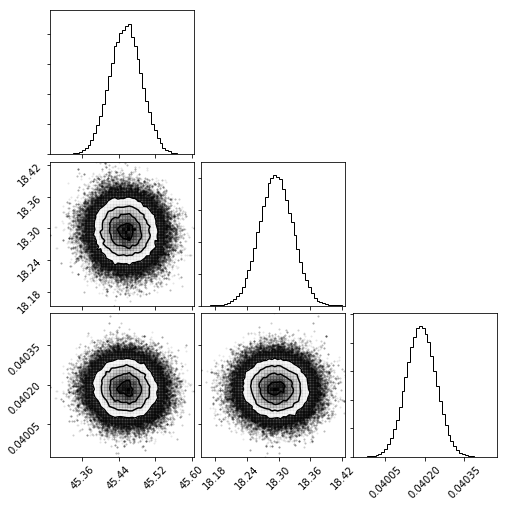

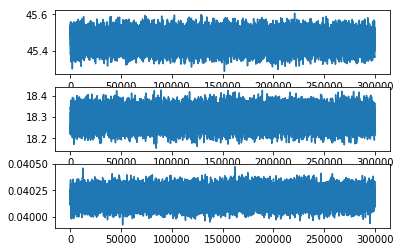

In [31]:
fig = corner.corner(chain, bins = 50)
samples = fullchain[:, 50:, :].reshape((-1, len(params)))
#samples = ba_combined.samples
pq = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, [1, 50, 99],axis=0))))
error_mcmc = []
print( "sep:", pq[0][0], "+", pq[0][1], "-",pq[0][2])
error_mcmc.append([pq[0][2], pq[0][1]])
print( "pa:", pq[1][0], "+", pq[1][1], "-",pq[1][2])
error_mcmc.append([pq[1][2], pq[1][1]])
print( "con:", pq[2][0], "+", pq[2][1], "-",pq[2][2])
error_mcmc.append([pq[2][2], pq[2][1]])

plt.figure()
for q in range(3):
    plt.subplot(3, 1, q+1)
    plt.plot(chain[:,q])

cons shape (500, 37)
uvcoords shape (2, 3, 120, 500, 37)
Computing model cps over 500 parameters.
Finished computing big grid, took 0.772978067398 s
model shape: (120, 500, 37)
new model shape (500, 120, 37)
datacps shape (500, 120, 37)
Time to finish contrast loop: 0.0978331565857 s


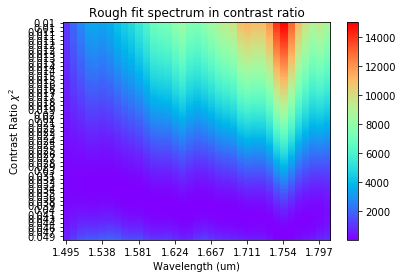

In [32]:
dof = 1/(10/3.0)
# The position recovered above
pos = 45.5, 18.3
ncons=500
spec = dof*binset.grid_spectrum(pos[0], pos[1], ncon=ncons, conlims = [1.0e-2, 5.0e-2])

[0.03287559 0.03287559 0.03276973 0.03341006 0.033518   0.0329818
 0.03308835 0.03395322 0.03529311 0.03586688 0.03621561 0.03764478
 0.03875354 0.03900434 0.03887874 0.0397665  0.04093776 0.04015315
 0.03887874 0.03862875 0.03938357 0.04054355 0.04080593 0.04120268
 0.04214351 0.04282865 0.04269074 0.04282865 0.04423253 0.0468765
 0.04825717 0.04672555 0.04451879 0.04324507 0.04241624 0.0416033
 0.04133579]
[[0.03706653 0.02633259 0.02285582 0.01952834 0.01944663 0.01936375
  0.01931804 0.01922677 0.01604527 0.01605231 0.01602874 0.01288493
  0.01611862 0.01287665 0.01284145 0.01280646 0.01281553 0.01603028
  0.01602387 0.01603034 0.012813   0.01282173 0.01282327 0.00966282
  0.0128775  0.00963444 0.01281983 0.01281035 0.00961327 0.00964452
  0.00965329 0.01287263 0.01281421 0.01276528 0.01600572 0.0096355
  0.01294853]
 [0.04214371 0.02566183 0.02234558 0.02231052 0.02221717 0.02212248
  0.01894779 0.01574052 0.01891586 0.01579551 0.01577232 0.01587415
  0.01270904 0.01586395 0.01582

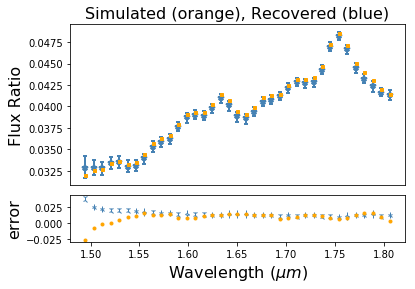

In [33]:
minval = np.zeros(spec.shape[0])
accept=[]
error = np.zeros(spec.shape[0])
plt.subplot2grid( (4,1), (0,0), rowspan=3)
for slc in range(spec.shape[0]):
    minval[slc] = binset.cons[spec[slc,:]==spec[slc,:].min()]
    accept.append(binset.cons[spec[slc,:] < 1 + spec[slc,:].min()])
    error[slc] = np.ptp(binset.cons[spec[slc,:] < 1 + spec[slc,:].min()])

errs = np.array([[abs(accept[f].max()-minval[f]) for f in range(spec.shape[0])], \
                 [abs(accept[f].min()-minval[f]) for f in range(spec.shape[0])]])
#plt.yscale("log")
# The data header contains the true spectrum
hdr = fits.getheader("../example_data/example_gpi/injectedbinary_S20140511E0013_spdc.fits")
true = np.array([hdr["CON_{0:02d}".format(c)] for c in range(37)])#[5:-5]
plt.title("Simulated (orange), Recovered (blue)", fontsize=16)
plt.ylabel("Flux Ratio", fontsize=16)
plt.errorbar(binset.wavls*1.0e6, true, fmt='s', color='orange', markersize=3)
plt.errorbar(binset.wavls*1.0e6, minval, yerr=errs, fmt='*', color="steelblue", 
             mew=2.0, capsize=2.0, elinewidth=2.0, barsabove=True)

plt.xticks([])
plt.subplot2grid((4,1), (3,0))
plt.errorbar(binset.wavls*1.0e6, (errs[1,:])/true, fmt='1', color='steelblue',mfc='w')
plt.errorbar(binset.wavls*1.0e6, (errs[0,:])/true, fmt='2', color='steelblue',mfc='w')
plt.errorbar(binset.wavls*1.0e6, (true-minval)/true, fmt='.', color='orange')
plt.ylabel("error", fontsize=16)
plt.xlabel("Wavelength ($\mu m$)", fontsize=16)
print( minval)
print( errs / true)

### Now we solve for everything

In [34]:
sep, pa = 45.5, 18.3
guess_spect = minval 
pguess = minval.copy()
params = np.array([sep, pa])
keys = ["sep",'pa']
for q in range(37):
    params = np.append(params, pguess[q])
    #keys.append("Rank {0}".format(q))
    keys.append("slc {0}".format(q))
print "params shape:", params.shape

nwalkers = 150
niter = 5000
p0 = [params + 0.1*params*np.random.rand(len(pguess)+2) for i in range(nwalkers)]
priors = [(35., 60.), (-180.0, 180.0)]
for f in range(len(pguess)):
    priors.append((0.01, 0.06))
#try:
#    sampler.reset()
#except:
#    pass
sampler = emcee.EnsembleSampler(nwalkers, len(pguess)+2, cp_binary_model,
                             args=[binset, priors])
t0 = time.time()
pos, prob, state = sampler.run_mcmc(p0, 500)
sampler.reset()
t1 = time.time()
#print "burn in complete, took ", t1-t0, "s"
pos, prob, state = sampler.run_mcmc(pos, niter)
t2 = time.time()
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print( "ran mcmc, took", t2 - t1, "s")
chain = sampler.flatchain
fullchain = sampler.chain
# If you want to save it:
#f = open("new_spectrum_sim/full_mcmc_39.pick", 'w')
#pickle.dump(fullchain, f)
#f.close()

params shape: (39,)
Mean acceptance fraction: 0.217
This number should be between ~ 0.25 and 0.5 if everything went as planned.
ran mcmc, took 727.531872034 s


In [19]:
samples = fullchain[:, 50:, :].reshape((-1, len(params)))
pqall = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, [1, 50, 99],axis=0))))


### Plot of the retrieved spectrum against the known input spectrum
If you run emcee over more iterations this will look better.

Text(0.5,0,'Wavelength ($\\mu m$)')

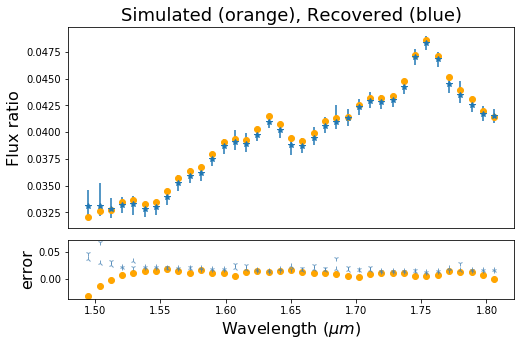

In [22]:
plt.figure(figsize=(8,5))
plt.subplot2grid((4,1), (0,0), rowspan=3)
plt.title("Simulated (orange), Recovered (blue)", fontsize=18)
plt.ylabel("Flux ratio", fontsize=16)
plt.errorbar(binset.wavls*1.0e6, true, fmt='o', color="orange")
samples = sampler.chain[:, 50:, :].reshape((-1, 4))
plt.errorbar(binset.wavls*1.0e6, [pqall[2+f][0] for f in range(37)], 
             yerr = ([pqall[2+f][2] for f in range(37)], [pqall[2+f][1] for f in range(37)]),fmt='*')
plt.xticks([])
plt.subplot2grid((4,1), (3,0))
plt.errorbar(binset.wavls*1.0e6, (true-np.array([pqall[2+f][0] for f in range(37)]))/true, fmt='o', color='orange')
plt.errorbar(binset.wavls*1.0e6, (np.array([pqall[2+f][1] for f in range(37)]))/true, color='steelblue', 
             fmt='1', alpha=0.75)
plt.errorbar(binset.wavls*1.0e6, (np.array([pqall[2+f][2] for f in range(37)]))/true, color='steelblue', 
             fmt='2', alpha=0.75)
plt.ylabel("error", fontsize=16)
plt.xlabel("Wavelength ($\mu m$)", fontsize=16)